## Grading Student Essays

In this notebook, I finetune a sequence classifier model from Hugging Face using the [Hewlett Foundation scored essay data set](https://www.kaggle.com/competitions/asap-aes/data).  
This dataset is taken from the training_set_rel3.xlsx on Kaggle. 
After changing the continuous scores to categories, the task is treated as a classification problem.

### 1 - Install and load required dependencies 

In [2]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    loralib==0.1.1 --quiet

%pip install matplotlib --quiet

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
pathos 0.3.1 requires dill>=0.3.7, but you have dill 0.3.6 which is incompatible.
pathos 0.3.1 requires multiprocess>=0.70.

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import mean_squared_error

## 2 - Define a DataSet Class

In [4]:
model_name = 'bert-base-uncased'

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, essays, grades):
        self.essays = essays
        self.grades = grades
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        essay = self.essays[idx]
        grade = self.grades[idx]
        tokens = self.tokenizer(essay, truncation=True, padding='max_length', max_length=512)
        return {key: torch.tensor(val, dtype=torch.long) for key, val in tokens.items()}, torch.tensor(grade, dtype=torch.float)


### 3 - Load data

In [5]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='categorised_essays.csv')
print(dataset)

Found cached dataset csv (/root/.cache/huggingface/datasets/csv/default-635f8d9d43b9c06c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'essay', 'category'],
        num_rows: 12978
    })
})


#### 3.1 Encode the labels as integers

In [6]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Function to encode the labels within the 'map' method
def encode_labels(example):
    example['encoded_labels'] = label_encoder.transform([example['category']])[0]
    return example

# Fit the LabelEncoder on the categories
label_encoder.fit(dataset['train']['category'])

# Use the 'map' function to apply the encoding to each example
dataset['train'] = dataset['train'].map(encode_labels, batched=False)

print(dataset)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-635f8d9d43b9c06c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-55ab6ca522103b74.arrow


DatasetDict({
    train: Dataset({
        features: ['essay_id', 'essay', 'category', 'encoded_labels'],
        num_rows: 12978
    })
})


#### 3.2 Save the label encoder so you can inverse transform the predictions later on 

In [7]:
import joblib

# Save the fitted LabelEncoder to a file so you can load it again and apply the inverse transform
joblib.dump(label_encoder, 'label_encoder.joblib')

# Later on, or in another script, you can load it back
#label_encoder = joblib.load('label_encoder.joblib')

# And then use it to inverse transform your predictions
#predicted_categories = label_encoder.inverse_transform(predictions)

['label_encoder.joblib']

#### 3.3 - Shuffle and sample a smaller dataset

In [8]:
# Shuffle the dataset
shuffled_dataset = dataset['train'].shuffle(seed=42)

# Select n random samples
n_samples = 2000
scored_essays = shuffled_dataset.select(range(n_samples))

print(scored_essays)


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-635f8d9d43b9c06c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-203d54942b8fa79c.arrow


Dataset({
    features: ['essay_id', 'essay', 'category', 'encoded_labels'],
    num_rows: 2000
})


#### 3.4 - Extract the essays and grades

In [9]:
essays = scored_essays['essay'] # list of essay strings
grades = scored_essays['encoded_labels'] # list of categorical grades

Split the data

In [10]:
from sklearn.model_selection import train_test_split

# Split into training and temporary sets (80/20 split)
essays_train, essays_temp, grades_train, grades_temp = train_test_split(
    essays, grades, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets (50/50 split)
essays_val, essays_test, grades_val, grades_test = train_test_split(
    essays_temp, grades_temp, test_size=0.5, random_state=42)


### 4 - Tokenize the data  
Create a dataset where each item is a tuple containing the tokenized essay and the corresponding categorical grade.  
These datasets can then be used to create DataLoaders which will handle batching of data for training.

In [11]:
train_dataset = EssayDataset(essays_train, grades_train)
val_dataset = EssayDataset(essays_val, grades_val)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#### 4.1 - Initialize the original model and optimizer

In [12]:
num_classes = 6
original_model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,  # this is the number of classes
    problem_type="single_label_classification"  # make sure to set this for single-label classification
)

optimizer = AdamW(original_model.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### 4.2 - Print the number of trainable model parameters

In [13]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 109486854
all model parameters: 109486854
percentage of trainable model parameters: 100.00%


### 5 - Full fine tuning



Train for 1 epoch to ensure the training and validation steps work.

In [21]:
from sklearn.metrics import accuracy_score, classification_report
import copy

n_epochs = 1  # Set a higher number of epochs to take advantage of early stopping
patience = 2  # Number of epochs to wait for improvement before stopping
patience_counter = 0  # To keep track of how many epochs without improvement
best_val_loss = float('inf')
best_model = None
original_model_path = './full-finetune-essay-categories' # Define a path to save the model


for epoch in range(n_epochs):
    # Training
    original_model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        # Unpack the tokenized tensors and encoded labels from the batch
        tokenized_tensors = batch[0]
        labels = batch[1]

        # Extract the tokenized tensors
        input_ids = tokenized_tensors['input_ids']
        attention_mask = tokenized_tensors['attention_mask']
        
        # Convert labels to long integers
        labels = labels.long()

        # Forward pass with labels to compute loss
        outputs = original_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Training loss: {avg_train_loss}')

    # Validation
    original_model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            # Unpack the tokenized tensors and labels from the batch
            tokenized_tensors = batch[0]
            labels = batch[1]

            input_ids = tokenized_tensors['input_ids']
            attention_mask = tokenized_tensors['attention_mask']

            # Convert labels to long integers
            labels = labels.long()

            # Forward pass, we don't provide labels during inference
            outputs = original_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            val_loss += outputs.loss.item()
            preds = torch.argmax(logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}, Validation loss: {avg_val_loss}')

    # Calculate classification metrics
    accuracy = accuracy_score(val_labels, val_preds)
    report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_)
    print(f'Validation Accuracy: {accuracy}')

    # Save model if validation loss has improved
    if avg_val_loss < best_val_loss:
        print(f'Validation loss decreased from {best_val_loss} to {avg_val_loss}. Saving model to {original_model_path}')
        best_val_loss = avg_val_loss
        best_model = copy.deepcopy(original_model.state_dict())
        patience_counter = 0
        
        # Save best model to disk
        # First ensure the best model weights are loaded
        original_model.load_state_dict(best_model)

        # Save model weights
        original_model.save_pretrained(original_model_path)

        # Save tokenizer from the train_dataset
        train_dataset.tokenizer.save_pretrained(original_model_path)
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
            
    print(report)


Epoch 1, Training loss: 0.4019169419631362
Epoch 1, Validation loss: 0.45629968523979186
Validation Accuracy: 0.825
Validation loss decreased from inf to 0.45629968523979186. Saving model to ./full-finetune-essay-categories
              precision    recall  f1-score   support

           A       1.00      0.95      0.98        21
           B       0.82      0.86      0.84        21
           C       0.84      0.80      0.82        20
           D       0.90      0.88      0.89        69
           E       0.51      0.74      0.61        27
           F       0.94      0.71      0.81        42

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.85      0.82      0.83       200



Save the best model and the corresponding tokenizer

In [22]:
# Ensure the best model weights are loaded
original_model.load_state_dict(best_model)

# Save model weights
original_model.save_pretrained(original_model_path)

# Save tokenizer from the train_dataset
train_dataset.tokenizer.save_pretrained(original_model_path)


('./full-finetune-essay-categories/tokenizer_config.json',
 './full-finetune-essay-categories/special_tokens_map.json',
 './full-finetune-essay-categories/vocab.txt',
 './full-finetune-essay-categories/added_tokens.json')

Optional: Reload model and tokenizer from file when needed

In [23]:
original_model = BertForSequenceClassification.from_pretrained(original_model_path)
tokenizer = BertTokenizer.from_pretrained(original_model_path)

### 6 - Parameter efficient fine tuning

#### 6.1 - Setup the PEFT/LoRA model for Fine-Tuning

Performing full-finetuning can lead to catastrophic forgetting because it changes all parameters on the model. Since PEFT only updates a small subset of parameters, it's more robust against this catastrophic forgetting effect.

Set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [28]:
%pip install peft==0.3.0 --quiet

from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    target_modules=["attention.self.query", "attention.self.value"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS # Sequence classificatio task
)


Note: you may need to restart the kernel to use updated packages.


#### 6.2 - Add LoRA adapter layers/parameters to the original LLM to be trained.

In [29]:
peft_model = get_peft_model(original_model, lora_config)

print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 1179648
all model parameters: 110671116
percentage of trainable model parameters: 1.07%


#### 6.3 - Train PEFT Adapter

Define training arguments and create `Trainer` instance.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
import copy

n_epochs = 20  # Set a higher number of epochs for early stopping
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0  # To keep track of how many epochs without improvement
best_val_loss = float('inf')
best_model = None
peft_model_path = './peft-essay-categories' # Define a path to save the model
optimizer = AdamW(peft_model.parameters(), lr=1e-3) # Higher learning rate than full fine tuning

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


for epoch in range(n_epochs):
    # Training
    peft_model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        # Unpack the tokenized tensors and encoded labels from the batch
        tokenized_tensors = batch[0]
        labels = batch[1]

        # Extract the tokenized tensors
        input_ids = tokenized_tensors['input_ids']
        attention_mask = tokenized_tensors['attention_mask']
        
        # Convert labels to long integers
        labels = labels.long()

        # Forward pass with labels to compute loss
        outputs = peft_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        loss.backward()  # Backward pass
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Training loss: {avg_train_loss}')

    # Validation
    peft_model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            # Unpack the tokenized tensors and labels from the batch
            tokenized_tensors = batch[0]
            labels = batch[1]

            input_ids = tokenized_tensors['input_ids']
            attention_mask = tokenized_tensors['attention_mask']

            # Convert labels to long integers
            labels = labels.long()

            # Forward pass, we don't provide labels during inference
            outputs = peft_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            val_loss += outputs.loss.item()
            preds = torch.argmax(logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch + 1}, Validation loss: {avg_val_loss}')
    
    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)

    # Calculate classification metrics
    accuracy = accuracy_score(val_labels, val_preds)
    report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_)
    print(f'Validation Accuracy: {accuracy}')

    # Save model if validation loss has improved
    if avg_val_loss < best_val_loss:
        print(f'Validation loss decreased from {best_val_loss} to {avg_val_loss}. Saving model to {peft_model_path}')
        best_val_loss = avg_val_loss
        best_model = copy.deepcopy(peft_model.state_dict())
        patience_counter = 0
        
        # Save best model to disk
        # First ensure the best model weights are loaded
        peft_model.load_state_dict(best_model)

        # Save model weights
        peft_model.save_pretrained(peft_model_path)

        # Save tokenizer from the train_dataset
        train_dataset.tokenizer.save_pretrained(peft_model_path)
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
            
    print(report)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training loss: 1.54435546875
Epoch 1, Validation loss: 1.34453125
Validation Accuracy: 0.455
Validation loss decreased from inf to 1.34453125. Saving model to ./peft-essay-categories


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A       0.60      0.14      0.23        21
           B       0.00      0.00      0.00        21
           C       0.50      0.40      0.44        20
           D       0.50      0.97      0.66        69
           E       0.17      0.22      0.19        27
           F       0.78      0.17      0.27        42

    accuracy                           0.46       200
   macro avg       0.42      0.32      0.30       200
weighted avg       0.47      0.46      0.38       200

Epoch 2, Training loss: 1.34390625
Epoch 2, Validation loss: 1.2125
Validation Accuracy: 0.555
Validation loss decreased from 1.34453125 to 1.2125. Saving model to ./peft-essay-categories
              precision    recall  f1-score   support

           A       1.00      0.10      0.17        21
           B       0.61      0.52      0.56        21
           C       0.75      0.30      0.43        20
           D       0.55      0.96      0.70        6

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A       0.75      0.14      0.24        21
           B       0.00      0.00      0.00        21
           C       0.52      0.65      0.58        20
           D       0.60      0.86      0.71        69
           E       0.24      0.48      0.32        27
           F       0.79      0.36      0.49        42

    accuracy                           0.52       200
   macro avg       0.48      0.41      0.39       200
weighted avg       0.54      0.52      0.47       200

Epoch 4, Training loss: 1.1851171875
Epoch 4, Validation loss: 1.07890625
Validation Accuracy: 0.615
Validation loss decreased from 1.2021875 to 1.07890625. Saving model to ./peft-essay-categories
              precision    recall  f1-score   support

           A       0.92      0.52      0.67        21
           B       0.67      0.29      0.40        21
           C       0.39      0.75      0.52        20
           D       0.66      0.74      0.70

#### Precision, Recall and F1 score

In the context of grading essays using a fine-tuned language model, the relative importance of precision and recall may depend on the specific objectives and consequences of the grading system.

Here are some considerations:

1. **Precision (Positive Predictive Value)**: Precision measures the accuracy of the positive predictions. In essay grading, a high precision would mean that when the model assigns a specific grade, it is usually correct. This is important when you want to ensure that students are only awarded a certain grade if their essays truly merit it. For example, if precision is crucial, you wouldn't want to give an "A" to a student unless you are quite certain their work deserves an "A".

2. **Recall (Sensitivity)**: Recall measures the ability of the model to find all the relevant cases (all the essays that truly deserve a particular grade). High recall in essay grading means that most essays that deserve a certain grade are correctly identified and assigned that grade by the model. This is important when it is crucial to identify all the students who deserve a particular grade. For instance, if every student who deserves an "A" must receive one, then recall is vital.

Depending on the context, you might prioritize differently:

- **If you are more concerned about fairness and equality**, you might prioritize recall to ensure that every student who deserves a high grade receives it, minimizing the chances that a high-quality essay is graded too harshly.
- **If you are more concerned about maintaining high standards**, you might prioritize precision to ensure that only truly outstanding essays receive the highest grades, minimizing the chances that a lower-quality essay is graded too leniently.

In many educational contexts, a balance between precision and recall is sought. This balance can be measured by the F1 score, which is the harmonic mean of precision and recall. The F1 score provides a single metric that takes into account both the precision and the recall. This is useful when you need to ensure that the grading model is both accurate and fair in assigning grades.

#### 6.4 - Save the final best model and the corresponding tokenizer 

In [81]:
# Ensure the best model weights are loaded
peft_model.load_state_dict(best_model)

# Save model weights
peft_model.save_pretrained(peft_model_path)

# Save tokenizer from the train_dataset
train_dataset.tokenizer.save_pretrained(peft_model_path)


('./peft-essay-categories/tokenizer_config.json',
 './peft-essay-categories/special_tokens_map.json',
 './peft-essay-categories/vocab.txt',
 './peft-essay-categories/added_tokens.json')

### 7 - Inference

#### 7.1 - Prepare this model by adding an adapter to the original model.   
Set is_trainable=False because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set is_trainable=True.

In [82]:
from peft import PeftModel, PeftConfig

peft_model_base = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, torch_dtype=torch.bfloat16)
tokenizer = BertTokenizer.from_pretrained(model_name)

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       peft_model_path, 
                                       torch_dtype=torch.bfloat16,
                                       num_labels=num_classes,
                                       is_trainable=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### 7.2 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences with the original model and PEFT model for one test instance initially.  
Please note the original model would normally be the fully fine tuned model.  
I have not fine tuned the original model fully to conserve resources.

In [83]:
index = 12

essay = essays_test[index]
category_label = grades_test[index]  # Assuming this is the original encoded category label

# Prepare the prompt and tokenize
prompt = f"Assign a score to the following essay:\n\n{essay}\n\nScore:"
inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Make sure your models are in evaluation mode
original_model.eval()
peft_model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    # Get model predictions
    original_model_outputs = original_model(**inputs)
    peft_model_outputs = peft_model(**inputs)

    # Extract the predicted class index from the outputs
    original_model_pred_index = torch.argmax(original_model_outputs.logits, dim=-1)
    peft_model_pred_index = torch.argmax(peft_model_outputs.logits, dim=-1)

    # Convert predicted indices to class labels using the label encoder
    original_model_label = label_encoder.inverse_transform([original_model_pred_index.cpu().numpy()])[0]
    peft_model_label = label_encoder.inverse_transform([peft_model_pred_index.cpu().numpy()])[0]
    category_label_true = label_encoder.inverse_transform([category_label])[0]
    

# Print results
print(f"ACTUAL CATEGORY: {category_label_true.item()}")
print(f"ORIGINAL MODEL PREDICTED CATEGORY: {original_model_label}")
print(f"PEFT MODEL PREDICTED CATEGORY: {peft_model_label}")


ACTUAL CATEGORY: F
ORIGINAL MODEL PREDICTED CATEGORY: E
PEFT MODEL PREDICTED CATEGORY: D


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 7.3 - Evaluate the performance on the test set

In [84]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

n=10 # print progress every nth batch
y_test = []
y_pred = []
max_length = 512  # Maximum length for BERT-based models

for index in range(len(essays_test)):
    
    essay = essays_test[index]
    category_label = grades_test[index]  # This is the original encoded category label
    
    prompt = f"""
    Assign a score to the following essay.
    
    {essay}
    
    Score:
    """

    # Prepare the essay and tokenize
    inputs = tokenizer(prompt, return_tensors="pt")

    # Check the length of the tokenized essay
    input_length = inputs.input_ids.size(1)
    if input_length > max_length:
        print(f"Skipping essay {index} with length {input_length}...")
        continue
    
    # Move tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make sure your models are in evaluation mode
    original_model.eval()
    peft_model.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
    # Get model predictions
        peft_model_outputs = peft_model(**inputs)

        # Extract the predicted class index from the outputs
        peft_model_pred_index = torch.argmax(peft_model_outputs.logits, dim=-1)

        # Convert predicted indices to class labels using the label encoder
        # Ensure that the output is reshaped to 1D if necessary.
        peft_model_label = label_encoder.inverse_transform(peft_model_pred_index.cpu().numpy().reshape(-1))[0]
        
        # Populate y_test and y_pred
        category_label_true=label_encoder.inverse_transform([category_label])[0]
        y_test.append(category_label_true.item()) 
        y_pred.append(peft_model_label)  
        
        # Print progress message every nth iteration
        if index % n == 0:
            print(f"Processing batch {index}/{len(essays_test)}")    


# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)


Processing batch 0/200


Token indices sequence length is longer than the specified maximum sequence length for this model (766 > 512). Running this sequence through the model will result in indexing errors


Skipping essay 5 with length 766...
Processing batch 10/200
Skipping essay 11 with length 834...
Skipping essay 20 with length 720...
Processing batch 30/200
Skipping essay 37 with length 624...
Processing batch 40/200
Skipping essay 42 with length 861...
Skipping essay 45 with length 576...
Skipping essay 49 with length 595...
Processing batch 50/200
Skipping essay 55 with length 570...
Skipping essay 57 with length 626...
Processing batch 60/200
Skipping essay 66 with length 776...
Processing batch 70/200
Skipping essay 71 with length 669...
Skipping essay 75 with length 539...
Skipping essay 76 with length 627...
Skipping essay 79 with length 611...
Processing batch 80/200
Skipping essay 83 with length 695...
Skipping essay 87 with length 996...
Skipping essay 89 with length 747...
Processing batch 90/200
Skipping essay 93 with length 525...
Skipping essay 98 with length 777...
Processing batch 100/200
Skipping essay 105 with length 588...
Skipping essay 109 with length 840...
Proce

#### Confusion matrix

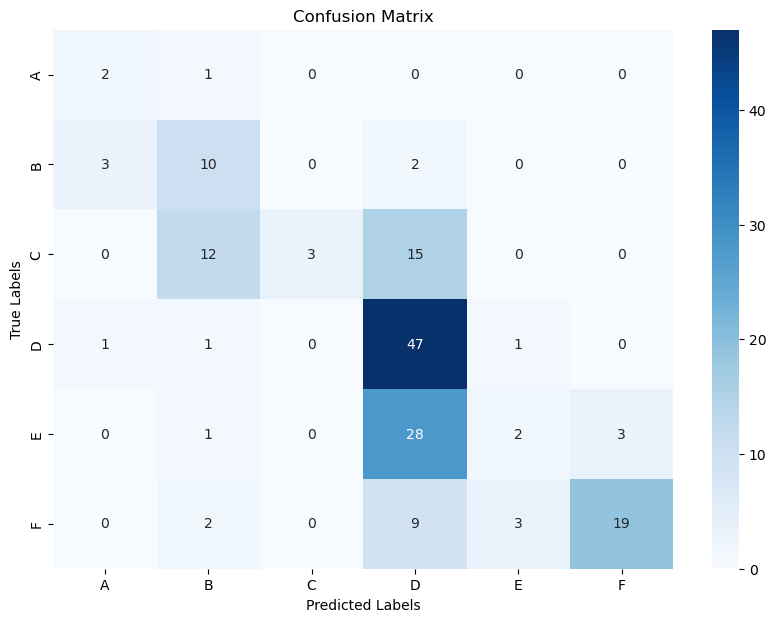

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["A", "B", "C", "D", "E", "F"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["A", "B", "C", "D", "E", "F"], yticklabels=["A", "B", "C", "D", "E", "F"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Save y_test and y_pred

In [92]:
import csv

# Combine y_test and y_pred into a single list of tuples for easier CSV writing
combined_data = list(zip(y_test, y_pred))

# Specify the CSV file path
csv_file_path = 'y_test_y_pred.csv'

# Writing to csv file
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # Optionally write header
    writer.writerow(['y_test', 'y_pred'])
    writer.writerows(combined_data)

# Return the path for download
csv_file_path


'y_test_y_pred.csv'

#### Combine classes

In [94]:
# Define a function to map old classes to new classes
def map_to_new_class(old_class):
    if old_class in ['A', 'B']:
        return 'AB'
    elif old_class in ['C', 'D']:
        return 'CD'
    elif old_class in ['E', 'F']:
        return 'EF'

# Map the original classes to the new classes
new_true_labels = [map_to_new_class(label) for label in y_test]
new_predictions = [map_to_new_class(label) for label in y_pred]
    
# Calculate the new classification report
new_report = classification_report(new_true_labels, new_predictions)
print(new_report)


              precision    recall  f1-score   support

          AB       0.48      0.89      0.63        18
          CD       0.62      0.81      0.71        80
          EF       0.96      0.40      0.57        67

    accuracy                           0.65       165
   macro avg       0.69      0.70      0.63       165
weighted avg       0.75      0.65      0.64       165



#### Confusion matrix

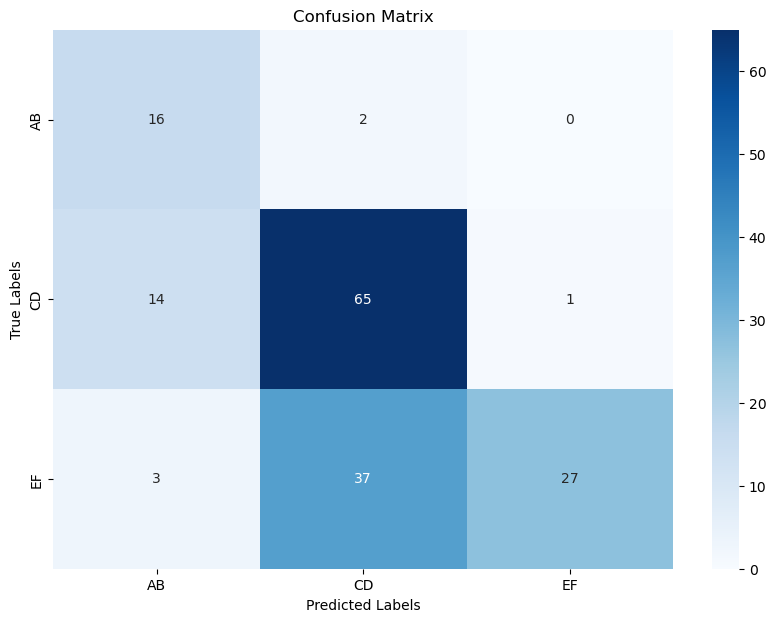

In [98]:
# Calculate the confusion matrix
cm = confusion_matrix(new_true_labels, new_predictions, labels=["AB", "CD", "EF"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["AB", "CD", "EF"], yticklabels=["AB","CD","EF"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
